In [ ]:
import pip

if int(pip.__version__.split('.')[0])>9:
    from pip._internal import main
else:
    from pip import main
    
def install(package):
    main(['install', package])

install('BeautifulSoup4')
install('numpy')
install('pandas')
install('matplotlib')

In [2]:
import re
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [3]:
seasons = [2014, 2015, 2016, 2017, 2018, 2019]
weeks = range(1, 17)
pos = {
    "D/ST": 99,
    "RB": 20,
    "WR": 30,
    "QB": 10
}
sample_url = 'https://www.fftoday.com/stats/playerstats.php?Season=2018&GameWeek=1&PosID=99&LeagueID=143908'

url_build = "https://www.fftoday.com/stats/playerstats.php?Season={season}&GameWeek={week}&PosID={pos}&LeagueID=143908"


def positionDataScrape(pos):
    data = []
    for season in seasons:
         for week in weeks:
            data += scrapePosBySeasonWeek(pos, season, week)
    sys.stdout.flush()
    return data

def scrapePosBySeasonWeek(pos, season, week):
    data = []
    url = url_build.format(season=season, week=week, pos=pos)
    sys.stdout.write("\rScrapping {}\t\t".format(url))

    stat_page = urlopen(url)
    stat_soup = BeautifulSoup(stat_page, 'html.parser')
    header = stat_soup.find('tr', class_='tableclmhdr')
    group_header = stat_soup.find('tr', class_='tablehdr')
    rows = header.find_next_siblings('tr')

    group_headers = []
    next_header_index = 0
    for td in group_header.find_all('td')[:-1]: # All group headers minus the last one which is always "Fantasy"
        num_headers = int(td['colspan'])
        group = { 'name': td.get_text().strip(), 'num_headers': num_headers, 'offset': next_header_index }
        group_headers.append(group)
        next_header_index += num_headers

    keys = []
    for td in header.find_all('td'):
        keys.append(td.get_text().strip())

    for group in group_headers:
        if group["name"] == '':
            continue
        span = slice(group['offset'], group['offset'] + group['num_headers'])
        keys[span] = ["{} - {}".format(group['name'], k) for k in keys[span]]


    keys.append('Season')
    keys.append('Week')


    for tr in rows:
        game = {k:None for k in keys}
        i = 0
        for td in tr.find_all('td'):
            game[keys[i]] = td.get_text().strip()
            i += 1
        game['Season'] = season
        game['Week'] = week
        game[keys[0]] = re.sub('^[\W\d]+', '', game[keys[0]])
        game[keys[0]] = re.sub('[\n\r\t]+', '', game[keys[0]])
        game[keys[0]] = re.sub('(s|S)ort\s', '', game[keys[0]]) # Remove the word "sort"
        data.append(game)
        
    return data

def customDefScoring(game):
    score = 0.0
    score += standardDefPts(game)
    if game['PA'] == 0:
        score += 20
    elif game['PA'] <= 6:
        score += 15
    elif game['PA'] <= 13:
        score += 10
    elif game['PA'] <= 20:
        score += 5
    elif game['PA'] <= 27:
        score += 0
    elif game['PA'] <= 34:
        score += -5
    elif game['PA'] >= 35:
        score += -10

    return score

def standardDefPts(game):
    return (1 * game['Sack']) + (2 * game['INT']) + (6 * game['DefTD']) + (6 * game['KickTD']) + (2 * game['Safety'])

In [4]:
data = positionDataScrape(pos["D/ST"])

Scrapping https://www.fftoday.com/stats/playerstats.php?Season=2019&GameWeek=16&PosID=99&LeagueID=143908		

In [5]:
df = pd.DataFrame(data)
df = df.astype({k:'float64' for k in df.columns[1:-2]})

In [6]:
df['CustFPts'] = df.apply(customDefScoring, axis=1)
df['ProposedCustFPts'] = df.apply(customDefScoring, axis=1)

In [7]:
wr_data = positionDataScrape(pos['WR'])

Scrapping https://www.fftoday.com/stats/playerstats.php?Season=2019&GameWeek=16&PosID=30&LeagueID=143908		

In [8]:
wr_df = pd.DataFrame(wr_data)
wr_df = wr_df.astype({k:'float64' for k in wr_df.columns[2:-2]})

In [9]:
rb_data = positionDataScrape(pos['RB'])
rb_df = pd.DataFrame(rb_data)
rb_df = rb_df.astype({k:'float64' for k in rb_df.columns[2:-2]})

Scrapping https://www.fftoday.com/stats/playerstats.php?Season=2019&GameWeek=16&PosID=20&LeagueID=143908		

In [10]:
qb_data = positionDataScrape(pos['QB'])
qb_df = pd.DataFrame(qb_data)
qb_df = qb_df.astype({k:'float64' for k in qb_df.columns[2:-2]})

Scrapping https://www.fftoday.com/stats/playerstats.php?Season=2019&GameWeek=16&PosID=10&LeagueID=143908		

In [15]:
qb_df['CustFPts'] = qb_df.apply(lambda game: game['FPts'] + (game['Passing - INT'] * -1) + (game['Passing - TD'] * 2) + (game['Passing - Yard'] * 0.01), axis=1)

In [81]:
# Update column names to strip out all the weird values.
qb_df.columns.values[0] = 'Player'
wr_df.columns.values[0] = 'Player'
rb_df.columns.values[0] = 'Player'

# Recomputes helper methods for us
qb_df.columns = qb_df.columns.values
wr_df.columns = wr_df.columns.values
rb_df.columns = rb_df.columns.values

# Playing for Keeps - Defense Scoring System

## TL;DR

The goal of the league was to have a fantasy league that was more like the NFL. To do this, we implemented new league rules, like trading draft picks and having keepers, and scoring rule changes. These scoring rules had 2 goals: 

- Make fantasy scoring easier to keep track of while on the couch
    - QB passing touchdowns are 6 points (instead of 4)
    - QB passing yards are a half point for every 10 yards (instead of .4 points per 10 yards)
    - Kickers are 3 points for any field goal (instead of distance affecting points)
    - Defenses start at 28 points. Every time the opponent scores a touchdown, your defense loses a touchdown (7 points) from the starting score.
- Make fantasy points more equal to real life value
    - Increased scoring for QBs makes them the highest scoring, thus ‘most valuable’ player on the field
    - Increased scoring for defenses made them similar in value to a QB, as defense is half of the NFL 

For the most part, we felt we succeeded. Only modeling points allowed (instead of also having yards allowed) and increasing the score for points allowed has created a scoring model very similar to a QB model. However, in re-evaluating our defensive scoring, we have found it’s too volatile, aka really low scores and really big scores happen too frequently. 

To help fix this issue, we are proposing a D/ST scoring change that will change scoring for Points Allowed to the 
below. NO PAST GAMES WILL BE AFFECTED.

- 0 points allowed: 	20 points (currently 28) 
- 1-6 points allowed: 	15 points (currently 21)
- 7-13 points allowed: 	10 points (currently 14)
- 14-20 points allowed: 5 points (currently 7)
- 21-27 points allowed: 0 points (currently 0)
- 28-34 points allowed: -5 points (currently -7)
- 35+ points allowed: 	-10 points (currently -14)

After running 5 years’ worth of games through this model, (THANK YOU WILL) it has proven to give us 21+ point games from defenses about as often as a wide receiver would score 21+ point games (7% of the time). 

To put this in a real-life perspective: 
- The highest scoring defensive game since 2012 (the Patriots last week) would score 47 in the new model, they scored 55 in the old model. They had 0 PA, 7 sacks, 4 interceptions, and 2 defensive touchdowns. 
- The Ravens who played the Dolphins in week 1 would score 17 in the new model, they scored 21 in the old model. They had 10 PA, 3 sacks, 2 interceptions.

You can look at the [stats section](#stats-appendix) for all the info we have on the current D/ST scoring and the proposed one (including team by team stats on each system by season).

## Last Sunday

The Patriot's Defensive performace last Sunday against Miami (week 2 of the 2019 season) was _the best_ defensive performance in terms of Fantansy points since the Titans defense and special teams destroyed Jacksonville in 2012 week 17. The Titans and Patriots each scored 37 fantansy points (using standard scoring).

However, the Patriots had a huge "one-up" on the Titans performance. Miami never scored. Titans had two special teams touchdowns that catipulted them to their 37 fantasy points (and 2 defense touchdowns off of 3 interceptions), however, Jacksonville still put 20 point on the board against the Titans defense.

## Why the hell does D/ST matter anyway

Well, some might say for Fantasy Football it _shouldn't_ matter. It's not typically considered a "skill" player position.

My 2¢ on that:

**bull shit**

Defense is half of football, and I like leagues where it gets treated (more) like it. I also recognize though, that unless you in an IDP league, a GM doesn't really get control over individual aspects of the defense or special teams. You're stuck with a whole team's ensemble. This makes it less deterministic, more volitile, and consequently harder to gauge a good defense and get a consistent score from them.

### We tried to make D/ST matter more

For our league, we tried to make D/ST matter more without the GMs having to deal with the time sink that is IDP. Our goal was to treat defenses more like a QB position in point and spread. Afterall, there's only one QB and only one D/ST starter. We thought this seemed reasonable pre-draft, and when we ran numbers (against season average and stats for the last 5 seasons), it also looked valid. You only had about 12% chance of a defense scoring 21+ fantasy points, and the average defensive fantasy points was right at 7 fantasy points. That was pretty much right up there with QBs who had 14 average fantasy points and a 28% chance of having a 21+ fantasy point performance.

We also added higher penalties for high PA. This helped mitigate, we thought, performances like the Titans. In standard scoring they were at 37 fantasy points, but with 20PA that game, our custom scoring only gave them 20pts. Still a good showing, but it helped balance the scales and valued the primary goal of the defense of stopping the opposing offense. After all, _that_ is at least more deterministic than more random "offense-like" scoring by the defense.

Text(0, 0.5, '# of player games')

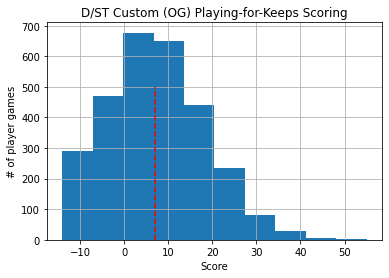

In [16]:
df.CustFPts.hist()
plt.title("D/ST Custom (OG) Playing-for-Keeps Scoring")
plt.vlines(df.CustFPts.mean(), 0, 500, ['r'], 'dashed', 'avg')
plt.xlabel("Score")
plt.ylabel("# of player games")

Text(0, 0.5, '# of player games')

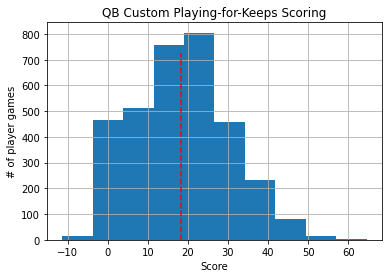

In [17]:
qb_df.CustFPts.hist()
plt.title("QB Custom Playing-for-Keeps Scoring")
plt.vlines(qb_df.CustFPts.mean(), 0, 725, ['r'], 'dashed', 'avg')
plt.xlabel("Score")
plt.ylabel("# of player games")

### Our assumption: strong defensive performances rarely include D/ST TDs

Our primary (perhaps naïve) assumption was that
> It's statistically _very unlikely_ for a defense to both have a shutout in PA **and** have high play-based scores.

In our analysis of our original custom scoring system (before the draft), of all the shutouts in the last 5 seasons  (on average about 5-6 a season), the average score was 36 fantasy points and the max ever seen was 47. We knew this was quite different from standard scoring because, but standard scoring values things like defensive touchdowns _way_ more (relatively) than keeping your opponent from geting touchdowns. 

You can see below, while we knew some high scores _could_ happen, they rarely happened. Only 1.4 games out of an entire _season_ would see a defense having a score of 40+ fantasy points. Compared to QBs that have 6.5 games a season at 40+ fantasy points.

In [18]:
df.where(df.PA == 0)[['FPts', 'CustFPts']].describe(percentiles=[0.25,0.50,0.75,0.90])

,FPts,CustFPts
count,32.000000,32.000000
mean,10.718750,37.218750
std,5.663889,5.481549
min,3.000000,31.000000
25%,6.750000,33.000000
50%,9.000000,36.000000
75%,14.250000,40.000000
90%,17.000000,44.600000
max,27.000000,55.000000


As we know now that week 2 and the Patriots absolute domination of Miami has come and gone, our assumption that strong shutouts doesn't have high play-based scores (TDs, many sacks, many interceptions, etc.) was proven to be wrong.

However, is this "the exception that proves the rule" or is it the game that proves that, inherently, the scoring allows big showings to just be bigger?

We've struggled with that for a few days now while looking through _game-by-game_ stats and crunching numbers.

### Volitility in D/ST fantasy points

So far, I would say the existing scoring system is "working as intended" by acting more like a QB (with just less likelihood of high scoring games) **except** in one point: volitility.

In stats, this is called "standard deviation". Typically, standard deviation is a good indicator of "volitility". If the standard deviation is way higher than the average (aka the "mean"), then getting a score near the average is very "uncertain".

In our original scoring system evaluation, that's one stat we didn't look at (because we didn't have game-by-game data to compare against). Unfortunately, the system had defenses scoring an average of 7.0 fantasy points, but the standard deviation was *11.5* fantasy points. That's a ratio of 1.6 times the average! 

It's easier if we visualize it:

Text(0, 0.5, '# of player games')

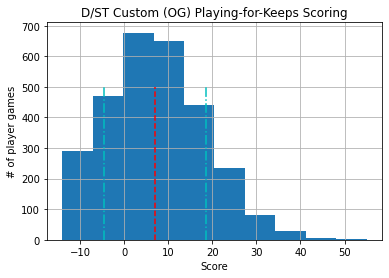

In [19]:
df_avg = df.CustFPts.mean()
df_std = df.CustFPts.std()
df.CustFPts.hist()
plt.title("D/ST Custom (OG) Playing-for-Keeps Scoring")
plt.vlines([df_avg, df_avg + df_std, df_avg - df_std], 0, 500, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")

The red line in the middle is the average, the cyan lines on either side are "1 standard deviation" away from the average. The wider the space between the blue bars, the more **dramatic** the volitility. However, all the dark blue inside that "1 standard deviation" range tells us how many games were in that range. You can see that there are a _lot_ of games covered inside the two cyan bars.

To be precise, the pecentage of games within 1 standard deviation of the average fantasy score is:

In [20]:
print("{0:.0%}".format(df.where(df.CustFPts >= (df_avg - df_std)).where(df.CustFPts <= (df_avg + df_std)).G.count() / df.G.count()))

64%


The closer to `50%` *and* the *wider* the 1 standard deviation range, the **more** volitile the fantasy score is.

Another way to say all this information is: "There is a 64% chance of my D/ST scoring 7.0 ± 11.5 points".

That means, as a GM, D/ST is a big risk-reward player. It could really hurt you on a bad week, but _really_ help you on a good week. That _doesn't_ tell us, though, how _likely_ you are to get a bad week versus a good week.

However, we're used to that same meta with another position, the QB. The QB has a standard deviation of *10.0* fantasy points, but it's a little offset by an average of 14.7 fantasy points (0.68 ratio).

66% of games are within 1 standard deviation


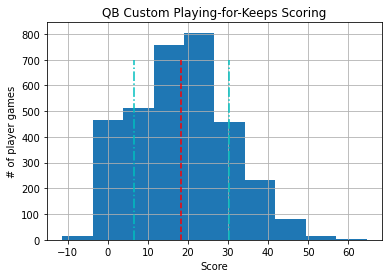

In [21]:
qb_avg = qb_df.CustFPts.mean()
qb_std = qb_df.CustFPts.std()
qb_df.CustFPts.hist()
plt.title("QB Custom Playing-for-Keeps Scoring")
plt.vlines([qb_avg, qb_avg + qb_std, qb_avg - qb_std], 0, 700, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("{0:.0%} of games are within 1 standard deviation".format(qb_df.where(qb_df.CustFPts >= (qb_avg - qb_std)).where(qb_df.CustFPts <= (qb_avg + qb_std)).G.count() / qb_df.G.count()))

In fact, QBs are _very_ similar to the D/ST (just very slightly less volitile). This brings us to the real problem, did everyone _expect_ the D/ST to be a 2nd QB?

### The primary "problem" with the current D/ST scoring system

The reason some of us our feeling the burn from the D/ST is two-fold:

1. Some (if not most) of us didn't expect a "second more-volitile QB" impact from the D/ST
2. The current meta is quite different from standard and while similar to a QB, is harder for GMs to gauge

While we talked about how we thought the D/ST meta would change during the initial setup of the league (and scoring rules were always visible to everyone), no one had a good feel for exactly _what_ value D/ST would have in the league. We couldn't give you game-by-game stats or team wide performances. Only the averages and typical performances for shutouts.

The second issue is part of the volitility that can make D/ST not fun as a GM. The first was entirely **our fault** as commissioners. In truth, while we shared what stats we had at prior to the draft, we didn't hit that home and do any game-by-game analysis. Probably, many of us would have tried to draft defenses a _little_ eariler in the draft process had we seen comparisons to other positions or standard scoring.

There isn't much we can do about the first part of the problem, but if we attempt to tweak the scoring system we _may_ help alleviate the second part and make the meta easier for us to gauge, and hopefully it'll make up a little for the first part of the problem.

### Proposed new scoring system

This is the new scoring system we're proposing:

- 0 PA : 20
- 1-6 PA: 15
- 7-13 PA: 10
- 14-20 PA: 5
- 21-26 PA: 0
- 27-34 PA: -5
- 35+ PA: -10
- all other scoring for Sacks, INTs, TDs, etc. will remain the same (which is currently standard scoring)

**This will only affect games going forward into the season**. This scoring change produces the following score distribution over the last 5 seasons:

avg: 6.4, standard deviation: 9.1
204 games at 21+ Fantasy Points (roughly 7.1% of games)
66% of games are within 1 standard deviation of the average fantasy score


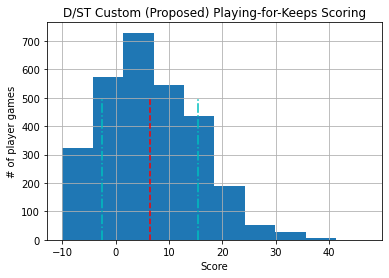

In [22]:
avg = df.ProposedCustFPts.mean()
std = df.ProposedCustFPts.std()
df.ProposedCustFPts.hist()
plt.title("D/ST Custom (Proposed) Playing-for-Keeps Scoring")
plt.vlines([avg, avg + std, avg - std], 0, 500, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(df.where(df.ProposedCustFPts > 20).G.count(), df.where(df.ProposedCustFPts > 20).G.count() / df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(df.where(df.ProposedCustFPts >= (avg - std)).where(df.ProposedCustFPts <= (avg + std)).G.count() / df.G.count()))

This score change bumps the average down by a little more than half a point, but bumps the max score seen in the last 5 full seasons by 8 points (from 47 to 39). It also tightens the deviation by about 2 points. This makes it less volitile then a QB, and close to a WR in likelihood to have a 21+ fantasy point game (WR is 6.7%).

Overall, as a GM, you're less likely to have your or your opponent's score dramatically changed due to the D/ST (but it _can_ still happen). At the same time, if you pick a good defense (or good defense matchup), you'll still have a good showing from the D/ST. For example, last Sunday the Patriots would have scored 47 (10 above standard) versus 55 (18 above standard).

You can go to the next section and see both the stats for the last 5 seasons for all D/STs in the NFL in both the current custom scoring system (`CustFPts`) and the Proposed (`ProposedCustFPts`).

## Thanks y'all

Feel free to give us feedback on this proposed change. We spent (probably too much) time on both evaluating the current scoring system and settling on the best and fairest candidate to propose as a replacement. We want you all to have all the same information as us, and are happy to discuss or provide you with all the data to play with as you will.

# stats-appendix

In [24]:
pd.options.display.max_rows = 500
print('"count" means the number of games in the table below... sorry')
df.groupby(by=["Team", "Season"])[["ProposedCustFPts"]].describe()

"count" means the number of games in the table below... sorry


ProposedCustFPts                                          \
                             count       mean        std   min   25%   50%   
Team       Season                                                            
Bears      2014               15.0   4.266667  10.559131  -9.0  -3.5   3.0   
           2015               15.0   3.466667   7.366591  -9.0  -1.0   4.0   
           2016               15.0   4.733333   9.160994 -10.0  -0.5   3.0   
           2017               15.0   8.066667   9.888425  -8.0   2.5   8.0   
           2018               15.0  13.200000  10.303952  -7.0  10.5  13.0   
           2019               15.0   7.666667   7.384024  -3.0   1.5   7.0   
Bengals    2014               15.0   6.800000  10.570849 -10.0   1.0  10.0   
           2015               15.0  10.333333   7.422617  -1.0   4.5  11.0   
           2016               15.0   6.133333   7.347173  -7.0   2.0   5.0   
           2017               15.0   6.800000   6.471917  -5.0   1.5   9.0   
           2018               15.0   2.200000   9.792125 -10.0  -5.5   2.0   
           2019               15.0   2.600000   7.566845  -8.0  -1.5   2.0   
Bills      2014               15.0  10.866667   9.022723  -8.0   5.0  11.0   
           2015               15.0   5.533333   9.077969  -9.0  -0.5   5.0   
           2016               15.0   6.666667  11.049671 -10.0  -3.0   6.0   
           2017               15.0   7.200000   9.151112 -10.0   1.5  11.0   
           2018               15.0   5.133333   9.241727  -8.0  -0.5   5.0   
           2019               15.0  10.066667   6.638273  -2.0   8.0  10.0   
Broncos    2014               15.0   6.600000   7.336796  -7.0   4.0   7.0   
           2015               15.0  11.800000   8.273883  -3.0   7.0  12.0   
           2016               15.0   9.466667   8.806383  -3.0   2.0  10.0   
           2017               15.0   5.333333   8.755950  -9.0   1.0   3.0   
           2018               15.0   8.000000   8.783101  -2.0   1.5   7.0   
           2019               15.0   7.933333   8.455486  -4.0   5.0   7.0   
Browns     2014               15.0   8.000000   7.387248  -2.0   2.0   8.0   
           2015               15.0   2.333333   8.372290  -9.0  -3.0  -2.0   
           2016               15.0  -0.266667   4.415341 -10.0  -3.0   0.0   
           2017               15.0   2.933333   5.257195  -4.0  -2.0   3.0   
           2018               15.0   4.733333   6.818742  -7.0  -1.5   8.0   
           2019               15.0   5.266667   9.098404  -8.0  -2.5   6.0   
Buccaneers 2014               15.0   5.200000   7.793770 -10.0   1.5   6.0   
           2015               15.0   4.933333   8.539544  -8.0   0.0   3.0   
           2016               15.0   6.200000  10.711809  -9.0  -2.0   4.0   
           2017               15.0   4.600000   8.666850  -5.0  -2.0   4.0   
           2018               15.0   1.266667   8.497619  -9.0  -5.0   0.0   
           2019               15.0   3.666667   9.626353  -9.0  -3.5   4.0   
Cardinals  2014               15.0  10.666667   9.529403  -9.0   6.5  11.0   
           2015               15.0  12.266667  10.673510  -1.0   4.5  10.0   
           2016               15.0   6.066667   9.277212  -5.0   0.0   3.0   
           2017               15.0   6.333333  10.265523  -4.0  -2.0   5.0   
           2018               15.0   3.800000   7.494760  -8.0  -2.0   5.0   
           2019               15.0   1.200000   5.918494  -8.0  -3.5   2.0   
Chargers   2014               15.0   4.600000   9.869144 -10.0  -2.5   3.0   
           2015               15.0   2.933333   5.762770  -9.0  -1.0   4.0   
           2016               15.0   5.266667   7.176018  -4.0  -0.5   6.0   
           2017               15.0  11.600000  10.012849  -4.0   5.5  10.0   
           2018               15.0   6.533333   8.871034  -9.0   1.5   5.0   
           2019               15.0   6.400000   6.987744  -8.0   2.0   3.0   
Chiefs     2014               15.0   8.8

avg: 6.2, standard deviation: 4.8
38 games at 21+ Fantasy Points (roughly 1.3% of games)
72% of games are within 1 standard deviation of the average fantasy score


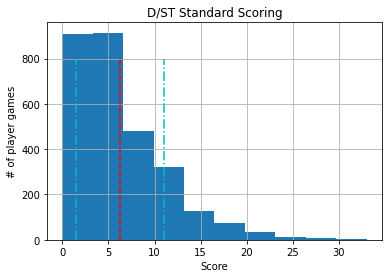

In [25]:
avg = df.FPts.mean()
std = df.FPts.std()
df.FPts.hist()
plt.title("D/ST Standard Scoring")
plt.vlines([avg, avg + std, avg - std], 0, 800, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(df.where(df.FPts > 20).G.count(), df.where(df.FPts > 20).G.count() / df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(df.where(df.FPts >= (avg - std)).where(df.FPts <= (avg + std)).G.count() / df.G.count()))

avg: 7.0, standard deviation: 11.6
352 games at 21+ Fantasy Points (roughly 12.2% of games)
64% of games are within 1 standard deviation of the average fantasy score


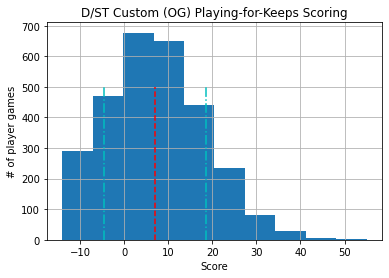

In [26]:
avg = df.CustFPts.mean()
std = df.CustFPts.std()
df.CustFPts.hist()
plt.title("D/ST Custom (OG) Playing-for-Keeps Scoring")
plt.vlines([avg, avg + std, avg - std], 0, 500, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(df.where(df.CustFPts > 20).G.count(), df.where(df.CustFPts > 20).G.count() / df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(df.where(df.CustFPts >= (avg - std)).where(df.CustFPts <= (avg + std)).G.count() / df.G.count()))

avg: 6.4, standard deviation: 9.1
204 games at 21+ Fantasy Points (roughly 7.1% of games)
66% of games are within 1 standard deviation of the average fantasy score


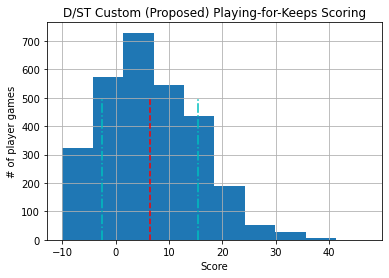

In [27]:
avg = df.ProposedCustFPts.mean()
std = df.ProposedCustFPts.std()
df.ProposedCustFPts.hist()
plt.title("D/ST Custom (Proposed) Playing-for-Keeps Scoring")
plt.vlines([avg, avg + std, avg - std], 0, 500, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(df.where(df.ProposedCustFPts > 20).G.count(), df.where(df.ProposedCustFPts > 20).G.count() / df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(df.where(df.ProposedCustFPts >= (avg - std)).where(df.ProposedCustFPts <= (avg + std)).G.count() / df.G.count()))

avg: 10.8, standard deviation: 5.5
324 games at 21+ Fantasy Points (roughly 6.8% of games)
74% of games are within 1 standard deviation of the average fantasy score


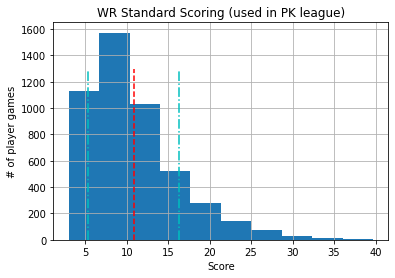

In [28]:
avg = wr_df.FPts.mean()
std = wr_df.FPts.std()
wr_df.FPts.hist()
plt.title("WR Standard Scoring (used in PK league)")
plt.vlines([avg, avg + std, avg - std], 0, 1300, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(wr_df.where(wr_df.FPts > 20).G.count(), wr_df.where(wr_df.FPts > 20).G.count() / wr_df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(wr_df.where(wr_df.FPts >= (avg - std)).where(wr_df.FPts <= (avg + std)).G.count() / wr_df.G.count()))

avg: 10.2, standard deviation: 6.8
471 games at 21+ Fantasy Points (roughly 9.8% of games)
76% of games are within 1 standard deviation of the average fantasy score


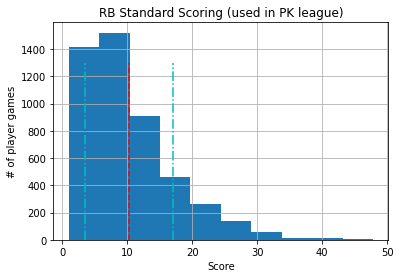

In [29]:
avg = rb_df.FPts.mean()
std = rb_df.FPts.std()
rb_df.FPts.hist()
plt.title("RB Standard Scoring (used in PK league)")
plt.vlines([avg, avg + std, avg - std], 0, 1300, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(rb_df.where(rb_df.FPts > 20).G.count(), rb_df.where(rb_df.FPts > 20).G.count() / rb_df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(rb_df.where(rb_df.FPts >= (avg - std)).where(rb_df.FPts <= (avg + std)).G.count() / rb_df.G.count()))

avg: 18.3, standard deviation: 11.9
1479 games at 21+ Fantasy Points (roughly 44.3% of games)
66% of games are within 1 standard deviation of the average fantasy score


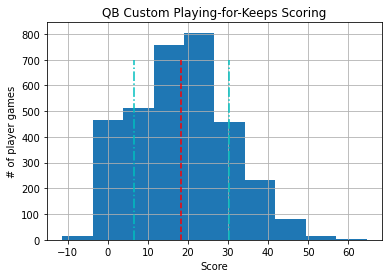

In [30]:
avg = qb_df.CustFPts.mean()
std = qb_df.CustFPts.std()
qb_df.CustFPts.hist()
plt.title("QB Custom Playing-for-Keeps Scoring")
plt.vlines([avg, avg + std, avg - std], 0, 700, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(qb_df.where(qb_df.CustFPts > 20).G.count(), qb_df.where(qb_df.CustFPts > 20).G.count() / qb_df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(qb_df.where(qb_df.CustFPts >= (avg - std)).where(qb_df.CustFPts <= (avg + std)).G.count() / qb_df.G.count()))

In [94]:
qb_df.where(qb_df.Season == 2019).groupby('Player').CustFPts.sum().sort_values(ascending=False).head(10)

Player
Lamar Jackson      512.97
Russell Wilson     398.07
Dak Prescott       393.29
Deshaun Watson     389.92
Jameis Winston     367.78
Patrick Mahomes    358.37
Josh Allen         344.14
Carson Wentz       337.30
Aaron Rodgers      335.09
Matt Ryan          328.43
Name: CustFPts, dtype: float64

In [100]:
rb_df.where(rb_df.Season == 2019).groupby('Player').FPts.sum().sort_values(ascending=False).head(10)

Player
Christian McCaffrey    337.4
Aaron Jones            251.5
Dalvin Cook            239.4
Derrick Henry          237.5
Ezekiel Elliott        233.3
Nick Chubb             215.0
Mark Ingram            212.5
Austin Ekeler          208.1
Chris Carson           195.6
Leonard Fournette      183.4
Name: FPts, dtype: float64

In [99]:
wr_df.where(wr_df.Season == 2019).groupby('Player').FPts.sum().sort_values(ascending=False).head(10)

Player
Michael Thomas     217.1
Chris Godwin       174.8
Kenny Golladay     164.2
Julio Jones        163.1
Mike Evans         160.9
DeVante Parker     152.1
Cooper Kupp        150.8
DeAndre Hopkins    149.9
Amari Cooper       149.3
Allen Robinson     143.4
Name: FPts, dtype: float64

In [107]:
df.where(df.Season == 2019).groupby('Team').ProposedCustFPts.sum().sort_values(ascending=False).head(10)

Team
Patriots    242.0
Steelers    173.0
ers         168.0
Ravens      155.0
Bills       151.0
Vikings     142.0
Chiefs      138.0
Rams        137.0
Packers     122.0
Saints      121.0
Name: ProposedCustFPts, dtype: float64